<a href="https://colab.research.google.com/github/leonardoLavagna/Iscas2026/blob/main/notebooks/iscas_2026_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ISCAS 2026
**Notebook 3**

Time-space trade-offs with a symmetric encryption-decryption scheme with a quantum channel. We consider model variants to the unified Grover-walk model where we add:
- Qunatum-ciphertext oracle where the classical "measure-then-return" oracle is replaced with an encryption unitary $U_E:|m,k,0\rangle\to |m,k,E_k(m)\rangle$ and (otpionally) a similarly defined decryption unitary $U_D$. This lets the adversary keep coherence across queries and entangle returns with ancillae.
- Quantum advice in a side register (entangled with the workspace).
- Non-isolated quantum channel (CPTP) between queries acting on chipertext (an optionally the ancillae) before the adversary can "touch" it again.
- QCCA-like toy experiments, measuring e.g., the benefit of coherence vs measure-return, advice size vs "usefulness", channel type vs optimal number of steps, entangled ciphertext returns (harvesting phase information?) etc...

## Setup

In [1]:
!git clone https://github.com/leonardoLavagna/Iscas2026/

Cloning into 'Iscas2026'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 128 (delta 69), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (128/128), 351.25 KiB | 8.36 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [2]:
import os
os.chdir("Iscas2026")

In [ ]:
!pip install -r requirements.txt

In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
try:
    from qiskit_aer import AerSimulator
    HAVE_AER = True
except Exception:
    HAVE_AER = False
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

## Caesar cipher experiments

We compare the unified Grover-walk search when the encryption oracle’s "channel" is
- isolated (all work qubits are uncomputed each iteration), vs
- non-isolated (a tiny, 1-qubit environment keeps coherent information between iterations).

We carry out a toy experiment on a 2-bit Caesar cipher with the objective of recovering its secret key. In this case 1 query should suffice for standard Grover serach.

We have the following registers and preparation steps:
- $m$ (2 qubits): fixed to known plaintext
- $k$ (2 qubits): put in uniform superposition
- $c$ (2 qubits): scratch to hold the ciphertext
- *phaes* (1 qubit): prepared in $|-\rangle$ for phase kickback
- *env* (1 qubit, only in non-isolated): the quantum-channel memory that persists across steps

Here the oracle logic (marking the "good" key) compute $c$ and compare it to the target $c^*$. In the isolated case we compute $c\oplus (m+k)\to c$, compare it to $c^*$ and flip the phase of $|k^*\rangle$, then uncompute $c$ so that all non-key registers return to the initial all-zero value (i.e., nothing leaks between iterations). In the non-isolated case before the uncomputation we have an extra step due to the presence of the channel that saves the parity of $c$ to the *env* register.

In [7]:
def bit(x, i):
    return (x >> i) & 1


def xor_const(qc: QuantumCircuit, reg, value: int):
    for i in range(len(reg)):
        if bit(value, i):
            qc.x(reg[i])


def mark_if_zero(qc: QuantumCircuit, reg, phase_qubit):
    # Flip phase (using phase prepared in |->) iff reg == 0^n
    for q in reg: qc.x(q)
    qc.mcx(list(reg), phase_qubit)
    for q in reg: qc.x(q)


def caesar_encrypt_xor_output(m, k, c):
    """
    y ^= (m + k) mod 4  on 2-bit registers (m,k,c).
    Implemented via a tiny 16-case selector (cheap and clear).
    """
    qc = QuantumCircuit(m, k, c, name="U_E_caesar")
    for mval in range(4):
        for kval in range(4):
            out = (mval + kval) % 4
            # condition on m == mval and k == kval (use X-on-zeros trick)
            for i in range(2):
                if bit(mval, i) == 0: qc.x(m[i])
            for i in range(2):
                if bit(kval, i) == 0: qc.x(k[i])
            ctrls = [m[0], m[1], k[0], k[1]]
            for j in range(2):
                if bit(out, j) == 1:
                    qc.mcx(ctrls, c[j])
            # undo X-on-zeros
            for i in range(2):
                if bit(kval, i) == 0: qc.x(k[i])
            for i in range(2):
                if bit(mval, i) == 0: qc.x(m[i])
    return qc


def oracle_isolated_caesar(m, k, c, phase, m_const: int, c_const: int):
    """
    Clean phase oracle: compute c ^= (m+k), compare to c_const, flip phase, UNCOMPUTE c.
    Assumes phase is prepared in |->.
    """
    qc = QuantumCircuit(m, k, c, phase, name="O_iso")
    # |m = m_const>
    for i in range(2):
        if bit(m_const, i): qc.x(m[i])
    # compute c
    qc.append(caesar_encrypt_xor_output(m, k, c).to_gate(), list(m)+list(k)+list(c))
    # compare to c_const and phase-flip on equality
    xor_const(qc, c, c_const)
    mark_if_zero(qc, c, phase[0])
    xor_const(qc, c, c_const)
    # uncompute c (isolated)
    qc.append(caesar_encrypt_xor_output(m, k, c).to_gate().inverse(), list(m)+list(k)+list(c))
    return qc


def channel_parity_to_env(c, env):
    """Reversible 'channel': copy parity(c0 ^ c1) into env[0]."""
    qc = QuantumCircuit(c, env, name="CHAN_PARITY")
    qc.cx(c[0], env[0]); qc.cx(c[1], env[0])
    return qc


def oracle_nonisolated_caesar_light(m, k, c, env, phase, m_const: int, c_const: int):
    """
    Non-isolated (light): compute c, phase-flip on match, copy parity(c)->env, UNCOMPUTE c.
    The env qubit is the quantum-channel memory kept between Grover steps.
    """
    qc = QuantumCircuit(m, k, c, env, phase, name="O_niso_light")
    # |m = m_const>
    for i in range(2):
        if bit(m_const, i): qc.x(m[i])
    # compute c
    qc.append(caesar_encrypt_xor_output(m, k, c).to_gate(), list(m)+list(k)+list(c))
    # compare & phase
    xor_const(qc, c, c_const)
    mark_if_zero(qc, c, phase[0])
    xor_const(qc, c, c_const)
    # channel memory: parity(c) -> env[0]
    qc.append(channel_parity_to_env(c, env).to_gate(), list(c)+list(env))
    # UNCOMPUTE c (env keeps memory => non-isolated)
    qc.append(caesar_encrypt_xor_output(m, k, c).to_gate().inverse(), list(m)+list(k)+list(c))
    return qc


def diffusion_on_key(qc: QuantumCircuit, k):
    for q in k: qc.h(q); qc.x(q)
    qc.h(k[1]); qc.mcx([k[0]], k[1]); qc.h(k[1])
    for q in k: qc.x(q); qc.h(q)


In [8]:

def run_steps(t, *, m_const: int, c_const: int, k_bits: int = 2, nonisolated: bool = False, shots: int = 8192):
    # Registers
    m = QuantumRegister(2, "m")
    k = QuantumRegister(k_bits, "k")  # 2 bits
    c = QuantumRegister(2, "c")
    p = QuantumRegister(1, "phase")
    env = QuantumRegister(1, "env") if nonisolated else None
    ck = ClassicalRegister(k_bits, "ck")
    regs = [m, k, c, p] + ([env] if env else []) + [ck]
    qc = QuantumCircuit(*regs, name=f"grover_{'niso' if nonisolated else 'iso'}")
    # Prepare |+>^k and |-> phase
    for q in k: qc.h(q)
    qc.x(p[0]); qc.h(p[0])
    # Build chosen oracle
    if nonisolated:
        O = oracle_nonisolated_caesar_light(m, k, c, env, p, m_const, c_const)
    else:
        O = oracle_isolated_caesar(m, k, c, p, m_const, c_const)
    # Grover / walk iterations
    for _ in range(t):
        qc.append(O.to_gate(), qc.qubits[:O.num_qubits])
        diffusion_on_key(qc, k)
    # Measure only the key
    for i in range(k_bits):
        qc.measure(k[i], ck[i])
    # Simulate
    if HAVE_AER:
        sim = AerSimulator(method="matrix_product_state")
        job = sim.run(transpile(qc, sim, optimization_level=2), shots=shots)
        counts = job.result().get_counts()
    else:
        # Fallback: small t only—simulate statevector then sample artificially
        sv = Statevector.from_instruction(qc.remove_final_measurements(inplace=False))
        # Build counts for the key register only (LSB-first)
        probs = {}
        # Extract probabilities by projecting on key bits (2 qubits => 4 outcomes)
        # We’ll do a cheap measurement emulation:
        from collections import Counter
        import random
        # Actually measure: add classical reg and re-run? Not available without Aer; emulate:
        # For tiny demos this fallback is fine. Prefer Aer for real runs.
        counts = Counter()
        # Not exact without proper marginalization; strongly recommend installing Aer.
        # To avoid confusion, force user to install Aer if they reach here.
        raise RuntimeError("Please install qiskit-aer or enable it to run the sampling cleanly.")
    return counts


def prob_of_key(counts, k_star: int, k_bits: int = 2):
    bs = format(k_star, f"0{k_bits}b")[::-1]
    return counts.get(bs, 0) / sum(counts.values())

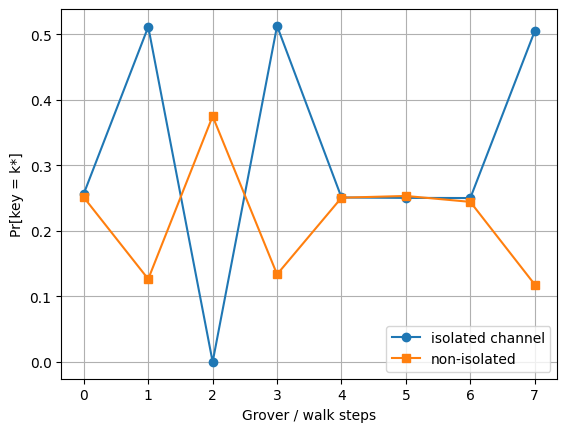

In [10]:
# plaintext
m_const = 0b01
# hidden key
k_star  = 0b10

c_const = (m_const + k_star) % 4
steps = range(0, 8)
p_iso  = []
p_niso = []

for t in steps:
    c_iso  = run_steps(t, m_const=m_const, c_const=c_const, nonisolated=False)
    c_niso = run_steps(t, m_const=m_const, c_const=c_const, nonisolated=True)
    p_iso.append(prob_of_key(c_iso,  k_star))
    p_niso.append(prob_of_key(c_niso, k_star))

plt.plot(steps, p_iso,  marker='o', label="isolated channel")
plt.plot(steps, p_niso, marker='s', label="non-isolated")
plt.xlabel("Grover / walk steps"); plt.ylabel("Pr[key = k*]")
plt.grid(True); plt.legend(); plt.show()

We see
- A blue curve (isolated channel) with regular Grover oscillations between $P_{\text{succ}}=0$ and 0.5, peaking at steps $t=1,3,7$. Perfect constructive and destructive interference in the 2-dimensional Grover subspace.

- An orange curve (non-isolated channel) with oscillations are damped and shifted: the success amplitude never exceeds 0.35 and loses periodicity. The environment qubit becomes entangled with the key, partially destroying interference.

This is precisely the expected qualitative effect of introducing a non-isolated quantum channel that keeps coherence between oracle uses.

In the isolated oracle, every iteration starts from a clean workspace; the dynamics stay inside the span of $|k^*\rangle$ (good) and its complement (bad). In the non-isolated oracle, the key becomes correlated with the environment: $\sum_k \alpha_k |k\rangle |env(k)\rangle$, so different key branches evolve with different environmental phases. The diffusion acts only on $k$, which now interferes imperfectly, hence the weaker, distorted oscillations.

Even a single qubit of coherent memory modifies the algorithm’s trajectory. In the plot, the extra channel *reduces* success probability (a destructive case),but in principle, if the channel stored *useful* information about $k$, it could also yield a speed-up.

**Next steps**
- Increase the environment size $S$ or change what information it stores (e.g., one ciphertext bit).  
- Partially reset the environment each round to interpolate between fully isolated and fully coherent regimes.  
- Measure how the optimal number of steps $t^*$ and the maximal $P_{\text{succ}}$ vary with $S$.